In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
from functools import partial

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM, step_eps
import jax_dataclasses as jdc
from models.models import MLP_lin,MLP
#from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2025-03-04 17:15:55.028175: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])
jax.config.update("jax_enable_x64", True)

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
def valid_points(Z, D, Q):
    def cond(point):
        return (point[0] ** 2 + point[1] ** 2 - 250**2 <= 0).astype(int)

    z_flat = Z.flatten()
    points = jnp.array([D.flatten(), Q.flatten()]).T
    val_points = jax.vmap(cond, in_axes=0)(points)
    z_flat_val = z_flat * val_points
    return z_flat_val.reshape(D.shape)


def eval_psi_and_L(expert_model):
    fig = plt.figure(figsize=(7, 12))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing="ij")
    learned_psi = {
        "Psi_d": expert_model.Psi_d,
        "Psi_q": expert_model.Psi_q,
        "L_dd": expert_model.L_dd,
        "L_dq": expert_model.L_dq,
        "L_qd": expert_model.L_qd,
        "L_qq": expert_model.L_qq,
    }

    for i, name in zip(range(6), ["Psi_d", "Psi_q", "L_dd", "L_dq", "L_qd", "L_qq"]):

        interp = expert_model.motor_env.LUT_interpolators[name]
        Z = interp((D, Q))

        Z = Z * 1000
        Z = valid_points(Z, D, Q)
        ax = fig.add_subplot(6, 3, 3 * i + 1, projection="3d")
        norm = plt.Normalize(Z.min(), Z.max())
        colors = cm.viridis(norm(Z))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
        surf.set_facecolor((0, 0, 0, 0))
        ax.azim = 225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title(name + " in mVs - LUT")
        else:
            ax.set_title(name + " in mH - LUT")

        mlp = learned_psi[name]
        z_flatt = jax.vmap(mlp)(
            jnp.array([D.flatten(), Q.flatten()]).T / expert_model.motor_env.env_properties.physical_constraints.i_d
        )  #
        Z_d = z_flatt.reshape(D.shape) * 1000

        Z_d = valid_points(Z_d, D, Q)

        ax = fig.add_subplot(6, 3, 3 * i + 2, projection="3d")
        norm = plt.Normalize(Z_d.min(), Z_d.max())
        colors = cm.viridis(norm(Z_d))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
        surf.set_facecolor((0, 0, 0, 0))
        ax.azim = 225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title(name + " in mVs - learned MLP")
        else:
            ax.set_title(name + " in mH - learned MLP")

        Z_difference = jnp.abs(Z - Z_d)  # np.abs
        ax = fig.add_subplot(6, 3, 3 * i + 3, projection="3d")
        norm = plt.Normalize(Z_difference.min(), Z_difference.max())
        colors = cm.viridis(norm(Z_difference))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
        surf.set_facecolor((0, 0, 0, 0))
        ax.azim = 225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        if i < 2:
            ax.set_title("abs. error in mVs")
        else:
            ax.set_title("abs. error in mH")
        ax.ticklabel_format(style="plain")

    fig.show()


def eval_det(expert_model):
    fig = plt.figure(figsize=(12, 8))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing="ij")

    def det_gt(i_dq):
        L_dd = motor_env.LUT_interpolators["L_dd"](i_dq)[0]
        L_dq = motor_env.LUT_interpolators["L_dq"](i_dq)[0]
        L_qd = motor_env.LUT_interpolators["L_qd"](i_dq)[0]
        L_qq = motor_env.LUT_interpolators["L_qq"](i_dq)[0]
        mat = jnp.array([[L_dd, L_dq], [L_qd, L_qq]])
        return jnp.linalg.det(mat)

    def det_model(i_dq):
        i_dq_norm = i_dq / motor_env.env_properties.physical_constraints.i_d
        mat = expert_model.L_matrix(i_dq_norm)
        return jnp.linalg.det(mat)

    L_det_gt = jax.vmap(det_gt)(jnp.array([D.flatten(), Q.flatten()]).T)  #
    L_det_gt = L_det_gt.reshape(D.shape)
    L_det_gt = valid_points(L_det_gt, D, Q)
    L_det_pred = jax.vmap(det_model)(jnp.array([D.flatten(), Q.flatten()]).T)  #
    L_det_pred = L_det_pred.reshape(D.shape)

    L_det_pred = valid_points(L_det_pred, D, Q)

    ax = fig.add_subplot(1, 3, 1, projection="3d")
    norm = plt.Normalize(L_det_gt.min(), L_det_gt.max())
    colors = cm.viridis(norm(L_det_gt))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, L_det_gt, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title("det_gt")

    ax = fig.add_subplot(1, 3, 2, projection="3d")
    norm = plt.Normalize(L_det_pred.min(), L_det_pred.max())
    colors = cm.viridis(norm(L_det_pred))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, L_det_pred, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title("det_pred")

    Z_difference = jnp.abs(L_det_gt - L_det_pred)  # np.abs
    ax = fig.add_subplot(1, 3, 3, projection="3d")
    norm = plt.Normalize(Z_difference.min(), Z_difference.max())
    colors = cm.viridis(norm(Z_difference))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.set_xlabel("i_d in A")
    ax.set_ylabel("i_q in A")
    ax.set_title("abs. error in mH")
    ax.ticklabel_format(style="plain")

    fig.show()
        

In [6]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_dq_mlp: MLP

    def __init__(self, motor_env, psi_layer_sizes, key):
        self.motor_env = motor_env
        key, subkey = jax.random.split(key)
        self.psi_dq_mlp = MLP(
            psi_layer_sizes, key=subkey, hidden_activation=jax.nn.swish, output_activation=jax.nn.tanh
        )

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations

    def step(self, obs, action, tau):
        obs1, _ = self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3 * 1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state = self.motor_env.generate_state_from_observation(obs1, self.motor_env.env_properties)
        # obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs, _ = self.step_expert(state, action, self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2], obs[4:6]])

    @partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm = i_dq / properties.physical_constraints.i_d

                p_d["Psi_d"] = self.Psi_d(i_dq_norm)
                p_d["Psi_q"] = self.Psi_q(i_dq_norm)
                p_d["L_dd"] = self.L_dd(i_dq_norm)
                p_d["L_dq"] = self.L_dq(i_dq_norm)
                p_d["L_qd"] = self.L_qd(i_dq_norm)
                p_d["L_qq"] = self.L_qq(i_dq_norm)

                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv = jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]

                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array(
                [self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)]
            )[0]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    @partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def Psi_d(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[0]  #  self.motor_env.LUT_interpolators["Psi_d"](i_dq)[0]

    def Psi_q(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[1]  #   self.motor_env.LUT_interpolators["Psi_q"](i_dq)[0]

    def Psi_d_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_d(i_dq_norm)

    def Psi_q_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_q(i_dq_norm)

    def l_d_dq(self, i_dq):
        return jax.grad(self.Psi_d_physical)(i_dq)

    def l_q_dq(self, i_dq):
        return jax.grad(self.Psi_q_physical)(i_dq)

    def L_dd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[0]

    def L_dq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[1]

    def L_qd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[0]

    def L_qq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[1]

    def L_matrix(self, i_dq):
        L_dd = self.L_dd(i_dq)
        L_dq = self.L_dq(i_dq)
        L_qd = self.L_qd(i_dq)
        L_qq = self.L_qq(i_dq)
        mat = jnp.array([[L_dd, L_dq], [L_qd, L_qq]])
        return mat


In [7]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

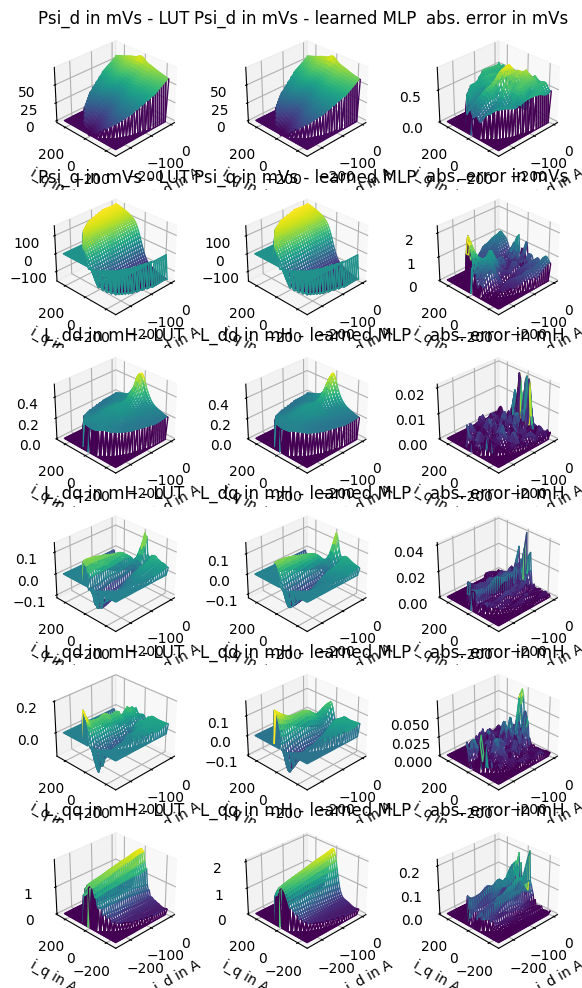

In [8]:
jax_key = jax.random.PRNGKey(14)
node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,128,2],key=jax_key)
node = eqx.tree_deserialise_leaves(f"final_models/grey_box/Model_4_128_1.eqx", node_struct) 
eval_psi_and_L(node)

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import gridspec
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
}
plt.rcParams.update(tex_fonts)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

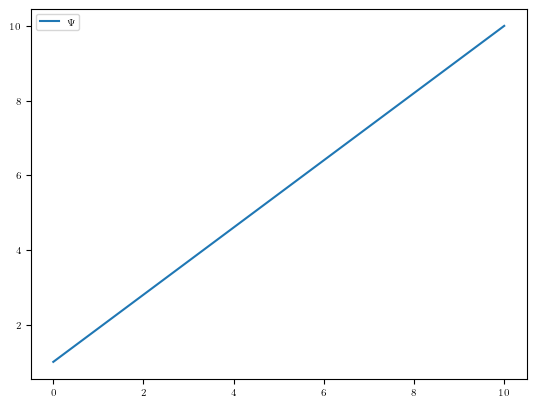

In [10]:
plt.plot(jnp.linspace(1,10,11),label=r"$\Psi$")
plt.legend()

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import gridspec
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 7,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
# }
# plt.rcParams.update(tex_fonts)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

def valid_points(Z, D, Q):
    def cond(point):
        return (point[0] ** 2 + point[1] ** 2 - 250**2 <= 0).astype(int)

    z_flat = Z.flatten()
    points = jnp.array([D.flatten(), Q.flatten()]).T
    val_points = jax.vmap(cond, in_axes=0)(points)
    z_flat_val = z_flat * val_points
    return z_flat_val.reshape(D.shape)



fig = plt.figure(figsize=(10, 6))
spec = gridspec.GridSpec(ncols=4, nrows=2,
                         width_ratios=[1,18,18,18], wspace=0.2,
                         hspace=0.1, height_ratios=[1,1],bottom=0.1)
xx = np.linspace(-250, 0, 26)
yy = np.linspace(-250, 250, 51)
D, Q = np.meshgrid(xx, yy, indexing="ij")
learned_psi = {
    "Psi_d": node.Psi_d,
    "Psi_q": node.Psi_q,
    "L_dd": node.L_dd,
    "L_dq": node.L_dq,
    "L_qd": node.L_qd,
    "L_qq": node.L_qq,
}
ax=fig.add_subplot(spec[0])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
ax=fig.add_subplot(spec[4])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
for i, name in zip(range(3), ["Psi_d", "L_dd", "L_dq"]):
    interp = node.motor_env.LUT_interpolators[name]
    Z = interp((D, Q))

    Z = Z * 1000
    Z = valid_points(Z, D, Q)
    Z = np.ma.masked_where(Z == 0, Z)
    ax = fig.add_subplot(spec[i+1], projection="3d")
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    # ax.set_xlabel(r"$i_{\mathrm{d}} \text{ in A}$", fontsize=11,labelpad=5)
    # ax.set_ylabel(r"$i_{\mathrm{q}} \text{ in A}$", fontsize=11, labelpad=5)
    # if i==0:
    #     ax.set_zlabel(r"$\mathit{\Psi}_{\mathrm{d}} \text{ in mVs}$",rotation = 90, fontsize=11, labelpad=2)
    # if i==1:
    #     ax.set_zlabel(r"$L_{\mathrm{dd}} \text{ in mH}$",rotation = 90, fontsize=11, labelpad=2)
    # if i==2:
    #     ax.set_zlabel(r"$L_{\mathrm{dq}} \text{ in mH}$",rotation = 90, fontsize=11, labelpad=2)
    # # if i==0:
    # #     ax.set_position([0.3, 0.53, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"$\text{LUT}$", fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.53, 0.3, 0.3]) 
    # if i==0:
    #     ax.set_box_aspect(None, zoom=0.85)
    # if i < 2:
    #     ax.set_title(name + " in mVs - LUT")
    # else:
    #     ax.set_title(name + " in mH - LUT")

    mlp = learned_psi[name]
    z_flatt = jax.vmap(mlp)(
        jnp.array([D.flatten(), Q.flatten()]).T / node.motor_env.env_properties.physical_constraints.i_d
    )  #
    Z_d = z_flatt.reshape(D.shape) * 1000

    Z_d = valid_points(Z_d, D, Q)
    Z_d = np.ma.masked_where(Z_d == 0, Z_d)
    ax = fig.add_subplot(spec[i+5], projection="3d")
    norm = plt.Normalize(Z_d.min(), Z_d.max())
    colors = cm.viridis(norm(Z_d))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    # ax.set_xlabel(r"$i_{\mathrm{d}} \text{ in A}$", fontsize=11,labelpad=5)
    # ax.set_ylabel(r"$i_{\mathrm{q}} \text{ in A}$", fontsize=11, labelpad=5)
    
    # if i==0:
    #     ax.set_position([0.3, 0.12, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"{NN}",fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.12, 0.3, 0.3]) 
    #ax.ticklabel_format(style="plain")
    if i==0:
        ax.set_zlabel(r"$\Psi$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
#fig.subplots_adjust(left=0.23)
#fig.subplots_adjust(left=0.25, wspace=0.3, hspace=0.3)
spec.tight_layout(fig,h_pad=2.5)
fig.show()
#fig.set_box_aspect(None, zoom=0.85)

#plt.savefig('pictures/Learned_LUTs2.pdf', bbox_inches="tight")
        

RuntimeError: latex was not able to process the following string:
b'$\\\\text{LUT}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpgqh6fdhh 7ce7f0cf89fc195726eb81b9fcbbadae.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7ce7f0cf89fc195726eb81b9fcbbadae.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7ce7f0cf89fc195726eb81b9fcbbadae.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \text 
                      
l.29 {\rmfamily $\text
                      {LUT}$}%
No pages of output.
Transcript written on tmpgqh6fdhh/7ce7f0cf89fc195726eb81b9fcbbadae.log.




Error in callback <function _draw_all_if_interactive at 0x7fb8c74680e0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'$\\\\text{LUT}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp3j0ej1tw 7ce7f0cf89fc195726eb81b9fcbbadae.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7ce7f0cf89fc195726eb81b9fcbbadae.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7ce7f0cf89fc195726eb81b9fcbbadae.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \text 
                      
l.29 {\rmfamily $\text
                      {LUT}$}%
No pages of output.
Transcript written on tmp3j0ej1tw/7ce7f0cf89fc195726eb81b9fcbbadae.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\text{LUT}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpt61b__66 7ce7f0cf89fc195726eb81b9fcbbadae.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7ce7f0cf89fc195726eb81b9fcbbadae.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 7ce7f0cf89fc195726eb81b9fcbbadae.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \text 
                      
l.29 {\rmfamily $\text
                      {LUT}$}%
No pages of output.
Transcript written on tmpt61b__66/7ce7f0cf89fc195726eb81b9fcbbadae.log.




<Figure size 1000x600 with 8 Axes>

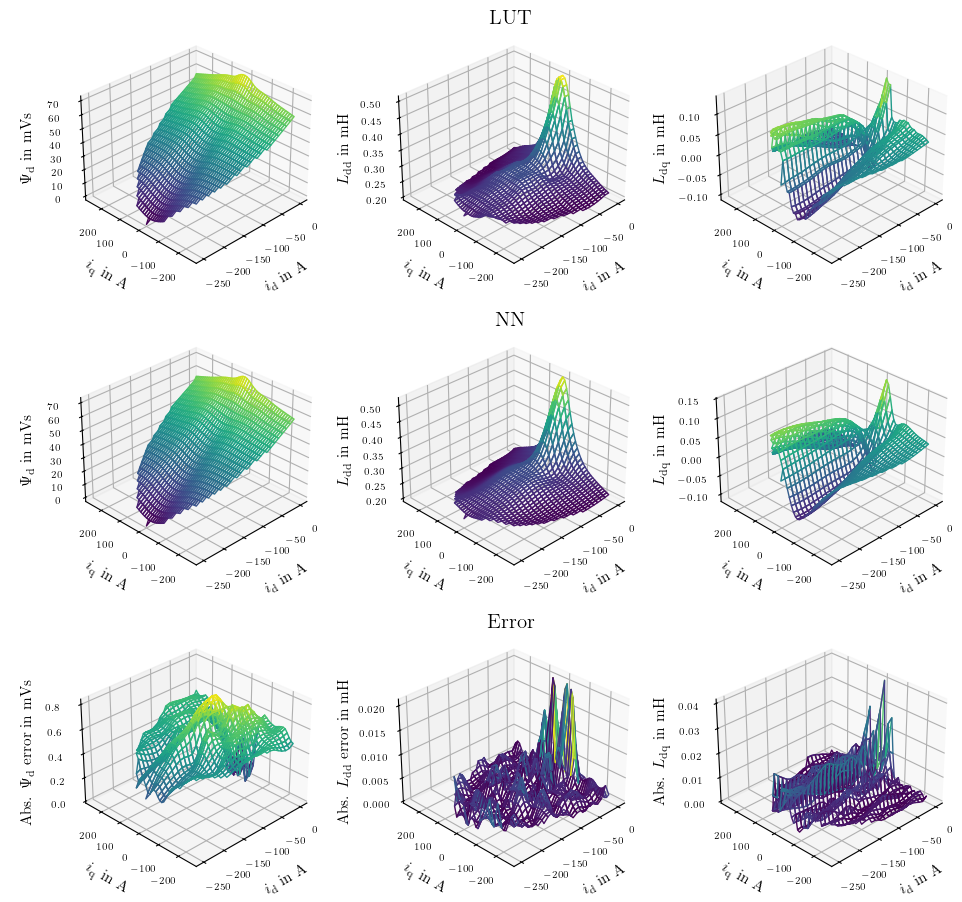

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import gridspec
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 7,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
# }
# plt.rcParams.update(tex_fonts)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

def valid_points(Z, D, Q):
    def cond(point):
        return (point[0] ** 2 + point[1] ** 2 - 250**2 <= 0).astype(int)

    z_flat = Z.flatten()
    points = jnp.array([D.flatten(), Q.flatten()]).T
    val_points = jax.vmap(cond, in_axes=0)(points)
    z_flat_val = z_flat * val_points
    return z_flat_val.reshape(D.shape)



fig = plt.figure(figsize=(10, 9))
spec = gridspec.GridSpec(ncols=4, nrows=3,
                         width_ratios=[1,18,18,18], wspace=0.2,
                         hspace=0.1, height_ratios=[1,1,1],bottom=0.1)
xx = np.linspace(-250, 0, 26)
yy = np.linspace(-250, 250, 51)
D, Q = np.meshgrid(xx, yy, indexing="ij")
learned_psi = {
    "Psi_d": node.Psi_d,
    "Psi_q": node.Psi_q,
    "L_dd": node.L_dd,
    "L_dq": node.L_dq,
    "L_qd": node.L_qd,
    "L_qq": node.L_qq,
}
ax=fig.add_subplot(spec[0])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
ax=fig.add_subplot(spec[4])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
ax=fig.add_subplot(spec[8])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
for i, name in zip(range(3), ["Psi_d", "L_dd", "L_dq"]):
    interp = node.motor_env.LUT_interpolators[name]
    Z = interp((D, Q))

    Z = Z * 1000
    Z = valid_points(Z, D, Q)
    Z_m=Z
    Z = np.ma.masked_where(Z == 0, Z)
    ax = fig.add_subplot(spec[i+1], projection="3d")
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    if i==0:
        ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    # if i==0:
    #     ax.set_position([0.3, 0.53, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"LUT", fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.53, 0.3, 0.3]) 
    # if i==0:
    #     ax.set_box_aspect(None, zoom=0.85)
    # if i < 2:
    #     ax.set_title(name + " in mVs - LUT")
    # else:
    #     ax.set_title(name + " in mH - LUT")

    mlp = learned_psi[name]
    z_flatt = jax.vmap(mlp)(
        jnp.array([D.flatten(), Q.flatten()]).T / node.motor_env.env_properties.physical_constraints.i_d
    )  #
    Z_d = z_flatt.reshape(D.shape) * 1000

    Z_d = valid_points(Z_d, D, Q)
    Z_d_m= Z_d
    Z_d = np.ma.masked_where(Z_d == 0, Z_d)
    ax = fig.add_subplot(spec[i+5], projection="3d")
    norm = plt.Normalize(Z_d.min(), Z_d.max())
    colors = cm.viridis(norm(Z_d))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    
    # if i==0:
    #     ax.set_position([0.3, 0.12, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"NN",fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.12, 0.3, 0.3]) 
    #ax.ticklabel_format(style="plain")
    if i==0:
        ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)


    Z_difference = jnp.abs(Z_m - Z_d_m)  # np.abs
    Z_difference = np.ma.masked_where(Z == 0, Z_difference)
    ax = fig.add_subplot(spec[i+9], projection="3d")
    norm = plt.Normalize(Z_difference.min(), Z_difference.max())
    colors = cm.viridis(norm(Z_difference))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False) 
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    if i==1:
        ax.set_title(r"Error",fontsize=15, pad=-200)

    if i==0:
        ax.set_zlabel(r"Abs. $\Psi_{\mathrm{d}}$ error in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"Abs. $L_{\mathrm{dd}}$ error in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"Abs. $L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
#fig.subplots_adjust(left=0.23)
#fig.subplots_adjust(left=0.25, wspace=0.3, hspace=0.3)
spec.tight_layout(fig,h_pad=2.5)
fig.show()
#fig.set_box_aspect(None, zoom=0.85)

plt.savefig('pictures/Learned_LUTs_full.pdf', bbox_inches="tight")
        

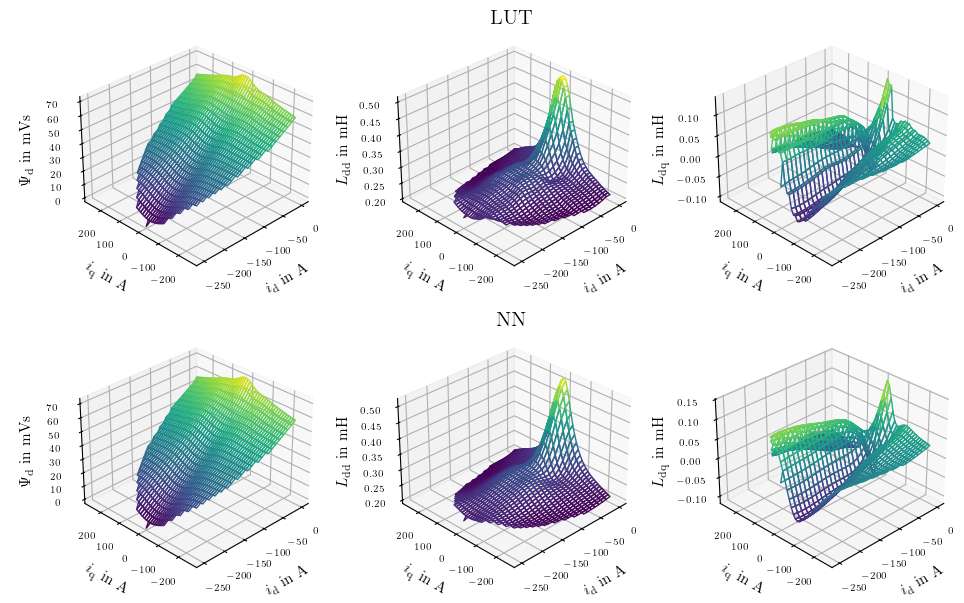

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import gridspec
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 7,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
# }
# plt.rcParams.update(tex_fonts)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

def valid_points(Z, D, Q):
    def cond(point):
        return (point[0] ** 2 + point[1] ** 2 - 250**2 <= 0).astype(int)

    z_flat = Z.flatten()
    points = jnp.array([D.flatten(), Q.flatten()]).T
    val_points = jax.vmap(cond, in_axes=0)(points)
    z_flat_val = z_flat * val_points
    return z_flat_val.reshape(D.shape)



fig = plt.figure(figsize=(10, 6))
spec = gridspec.GridSpec(ncols=4, nrows=2,
                         width_ratios=[1,18,18,18], wspace=0.2,
                         hspace=0.1, height_ratios=[1,1],bottom=0.1)
xx = np.linspace(-250, 0, 26)
yy = np.linspace(-250, 250, 51)
D, Q = np.meshgrid(xx, yy, indexing="ij")
learned_psi = {
    "Psi_d": node.Psi_d,
    "Psi_q": node.Psi_q,
    "L_dd": node.L_dd,
    "L_dq": node.L_dq,
    "L_qd": node.L_qd,
    "L_qq": node.L_qq,
}
ax=fig.add_subplot(spec[0])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
ax=fig.add_subplot(spec[4])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
for i, name in zip(range(3), ["Psi_d", "L_dd", "L_dq"]):
    interp = node.motor_env.LUT_interpolators[name]
    Z = interp((D, Q))

    Z = Z * 1000
    Z = valid_points(Z, D, Q)
    Z_m=Z
    Z = np.ma.masked_where(Z == 0, Z)
    ax = fig.add_subplot(spec[i+1], projection="3d")
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    if i==0:
        ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    # if i==0:
    #     ax.set_position([0.3, 0.53, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"LUT", fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.53, 0.3, 0.3]) 
    # if i==0:
    #     ax.set_box_aspect(None, zoom=0.85)
    # if i < 2:
    #     ax.set_title(name + " in mVs - LUT")
    # else:
    #     ax.set_title(name + " in mH - LUT")

    mlp = learned_psi[name]
    z_flatt = jax.vmap(mlp)(
        jnp.array([D.flatten(), Q.flatten()]).T / node.motor_env.env_properties.physical_constraints.i_d
    )  #
    Z_d = z_flatt.reshape(D.shape) * 1000

    Z_d = valid_points(Z_d, D, Q)
    Z_d_m= Z_d
    Z_d = np.ma.masked_where(Z_d == 0, Z_d)
    ax = fig.add_subplot(spec[i+5], projection="3d")
    norm = plt.Normalize(Z_d.min(), Z_d.max())
    colors = cm.viridis(norm(Z_d))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    
    # if i==0:
    #     ax.set_position([0.3, 0.12, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"NN",fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.12, 0.3, 0.3]) 
    #ax.ticklabel_format(style="plain")
    if i==0:
        ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)

#fig.subplots_adjust(left=0.23)
#fig.subplots_adjust(left=0.25, wspace=0.3, hspace=0.3)
spec.tight_layout(fig,h_pad=2.5)
fig.show()
#fig.set_box_aspect(None, zoom=0.85)

plt.savefig('pictures/Learned_LUTs_ex.pdf', bbox_inches="tight")
        

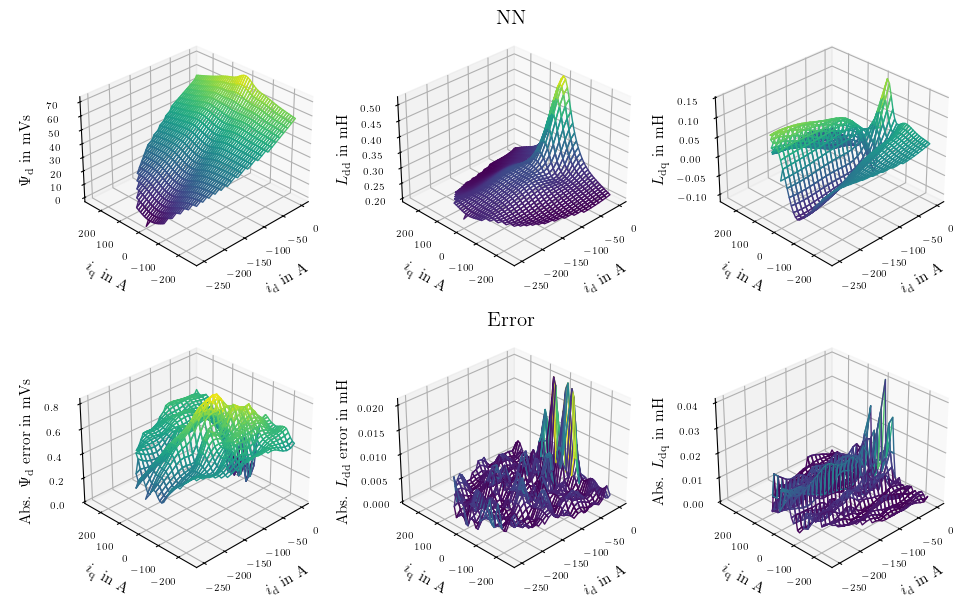

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import gridspec
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 7,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
# }
# plt.rcParams.update(tex_fonts)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

def valid_points(Z, D, Q):
    def cond(point):
        return (point[0] ** 2 + point[1] ** 2 - 250**2 <= 0).astype(int)

    z_flat = Z.flatten()
    points = jnp.array([D.flatten(), Q.flatten()]).T
    val_points = jax.vmap(cond, in_axes=0)(points)
    z_flat_val = z_flat * val_points
    return z_flat_val.reshape(D.shape)



fig = plt.figure(figsize=(10, 6))
spec = gridspec.GridSpec(ncols=4, nrows=2,
                         width_ratios=[1,18,18,18], wspace=0.2,
                         hspace=0.1, height_ratios=[1,1],bottom=0.1)
xx = np.linspace(-250, 0, 26)
yy = np.linspace(-250, 250, 51)
D, Q = np.meshgrid(xx, yy, indexing="ij")
learned_psi = {
    "Psi_d": node.Psi_d,
    "Psi_q": node.Psi_q,
    "L_dd": node.L_dd,
    "L_dq": node.L_dq,
    "L_qd": node.L_qd,
    "L_qq": node.L_qq,
}
ax=fig.add_subplot(spec[0])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
ax=fig.add_subplot(spec[4])
clust_data = np.random.random((1,1))
collabel=("col 1")
ax.axis('tight')
ax.axis('off')
#the_table = ax.table(cellText=clust_data,colLabels=collabel,loc='center')
for i, name in zip(range(3), ["Psi_d", "L_dd", "L_dq"]):
    interp = node.motor_env.LUT_interpolators[name]
    Z = interp((D, Q))

    Z = Z * 1000
    Z = valid_points(Z, D, Q)
    Z_m=Z
    Z = np.ma.masked_where(Z == 0, Z)
    # ax = fig.add_subplot(spec[i+1], projection="3d")
    # norm = plt.Normalize(Z.min(), Z.max())
    # colors = cm.viridis(norm(Z))
    # rcount, ccount, _ = colors.shape
    # surf = ax.plot_surface(D, Q, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    # surf.set_facecolor((0, 0, 0, 0))
    # ax.azim = 225
    # ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    # #ax.set_zlabel('label text', rotation=90)
    # ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    # ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    # if i==0:
    #     ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    # if i==1:
    #     ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    # if i==2:
    #     ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    # # if i==0:
    # #     ax.set_position([0.3, 0.53, 0.3, 0.3]) 
    # if i==1:
    #     ax.set_title(r"LUT", fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.53, 0.3, 0.3]) 
    # if i==0:
    #     ax.set_box_aspect(None, zoom=0.85)
    # if i < 2:
    #     ax.set_title(name + " in mVs - LUT")
    # else:
    #     ax.set_title(name + " in mH - LUT")

    mlp = learned_psi[name]
    z_flatt = jax.vmap(mlp)(
        jnp.array([D.flatten(), Q.flatten()]).T / node.motor_env.env_properties.physical_constraints.i_d
    )  #
    Z_d = z_flatt.reshape(D.shape) * 1000

    Z_d = valid_points(Z_d, D, Q)
    Z_d_m= Z_d
    Z_d = np.ma.masked_where(Z_d == 0, Z_d)
    ax = fig.add_subplot(spec[i+1], projection="3d")
    norm = plt.Normalize(Z_d.min(), Z_d.max())
    colors = cm.viridis(norm(Z_d))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.set_zlabel('label text', rotation=90)
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    
    # if i==0:
    #     ax.set_position([0.3, 0.12, 0.3, 0.3]) 
    if i==1:
        ax.set_title(r"NN",fontsize=15, pad=-200)
    # if i==2:
    #     ax.set_position([0.7, 0.12, 0.3, 0.3]) 
    #ax.ticklabel_format(style="plain")
    if i==0:
        ax.set_zlabel(r"$\Psi_{\mathrm{d}}$ in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"$L_{\mathrm{dd}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"$L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)


    Z_difference = jnp.abs(Z_m - Z_d_m)  # np.abs
    Z_difference = np.ma.masked_where(Z == 0, Z_difference)
    ax = fig.add_subplot(spec[i+5], projection="3d")
    norm = plt.Normalize(Z_difference.min(), Z_difference.max())
    colors = cm.viridis(norm(Z_difference))
    rcount, ccount, _ = colors.shape
    surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
    surf.set_facecolor((0, 0, 0, 0))
    ax.azim = 225
    ax.zaxis.set_rotate_label(False) 
    ax.set_xlabel(r"$i_{\mathrm{d}}$ in A", fontsize=11,labelpad=5)
    ax.set_ylabel(r"$i_{\mathrm{q}}$ in A", fontsize=11, labelpad=5)
    if i==1:
        ax.set_title(r"Error",fontsize=15, pad=-200)

    if i==0:
        ax.set_zlabel(r"Abs. $\Psi_{\mathrm{d}}$ error in mVs",rotation = 90, fontsize=11, labelpad=2)
    if i==1:
        ax.set_zlabel(r"Abs. $L_{\mathrm{dd}}$ error in mH",rotation = 90, fontsize=11, labelpad=2)
    if i==2:
        ax.set_zlabel(r"Abs. $L_{\mathrm{dq}}$ in mH",rotation = 90, fontsize=11, labelpad=2)
#fig.subplots_adjust(left=0.23)
#fig.subplots_adjust(left=0.25, wspace=0.3, hspace=0.3)
spec.tight_layout(fig,h_pad=2.5)
fig.show()
#fig.set_box_aspect(None, zoom=0.85)

plt.savefig('pictures/Learned_LUTs_nn_error.pdf', bbox_inches="tight")
        

## Model Learning